In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import matplotlib as mpl
import os
from glob import glob

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
results_df.sample()

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierBottomUp.py', '../models/SimplifierBottomUpOnlyLast.py', '../models/SimplifierBottomUpMAB.py', '../models/SimplifierTopDown.py', '../models/Vanilla.py', '../models/SimplifierTopDownOnlyLast.py'] ['Bottom Up', 'Bottom Up (only last)', 'Bottom Up MAB', 'Top Down', 'Without simplify', 'Top Down (only last)']
(53, 14)
['Bottom Up' 'Bottom Up MAB' 'Without simplify']
['Airfoil' 'Concrete']
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 100]


In [2]:
all_data = []
for i, row in results_df.iterrows():
    model, dataset, random_state = row.loc[['model', 'dataset', 'random_state']]

    files = glob(f"{results_path}/{dnames_to_ugly[dataset]}/{nice_to_ugly[model]}/"
                f"*{random_state}_evolution.csv")

    for file in files:
        data = pd.read_csv(file)
        
        for gen in gens:
            try:
                row = data[data['gen']==gen].iloc[0] # should have just 1 row
            except Exception as e:
                print(e)
                # print(file, gen)
                # print(row)
                continue
            
            all_data.append((model, dataset, *row))
            
all_data_df = pd.DataFrame(all_data, 
                           columns=(
                               'model',
                               'dataset',
                               *row.index
                           ))

all_data_df = all_data_df.replace([np.inf, -np.inf], np.nan).dropna()

print(all_data_df.shape)
print(all_data_df['model'].unique())
print(all_data_df['dataset'].unique())
all_data_df.sample(5)

(570, 27)
['Bottom Up' 'Bottom Up MAB' 'Without simplify']
['Airfoil' 'Concrete']


,model,dataset,gen,evals,best_size,n_simplifications,n_new_hashes,avg train error,avg train size,avg val error,...,std val error,std val size,min train error,min train size,min val error,min val size,max train error,max train size,max val error,max val size
429,Bottom Up,Concrete,10.0,40.0,3.0,15.0,39.0,293.912518,1.250,291.242464,...,124.868081,0.661438,240.875115,1.0,235.342368,1.0,1106.833804,3.0,1066.376218,3.0
527,Without simplify,Concrete,100.0,40.0,28.0,0.0,0.0,80.983866,28.300,90.249773,...,1.073079,0.556776,80.502263,28.0,88.845481,28.0,84.353670,30.0,93.821697,30.0
576,Without simplify,Concrete,50.0,40.0,21.0,0.0,0.0,129.901680,17.225,131.181063,...,8.479949,1.604486,125.387800,14.0,127.777270,14.0,187.141148,21.0,169.716044,21.0
285,Without simplify,Airfoil,100.0,40.0,21.0,0.0,0.0,24.706215,21.150,25.929786,...,0.030160,2.574393,24.633117,20.0,25.869466,20.0,24.724726,30.0,25.944971,30.0
36,Bottom Up,Airfoil,40.0,40.0,7.0,35.0,13.0,43.391420,6.850,45.235522,...,0.750990,0.653835,43.126001,4.0,44.996484,4.0,45.727762,7.0,47.844060,7.0


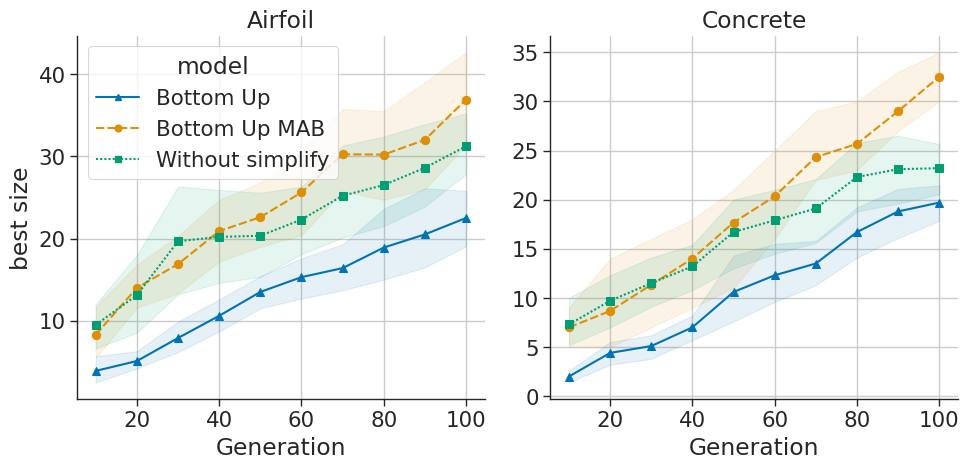

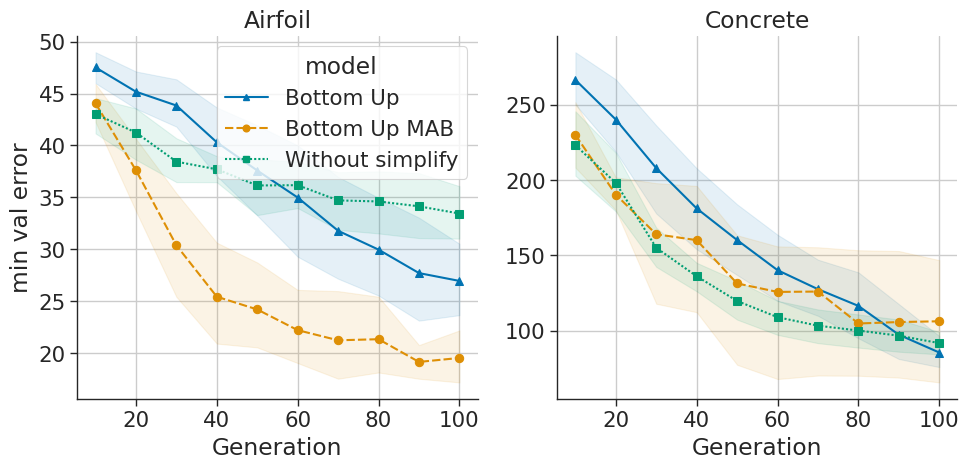

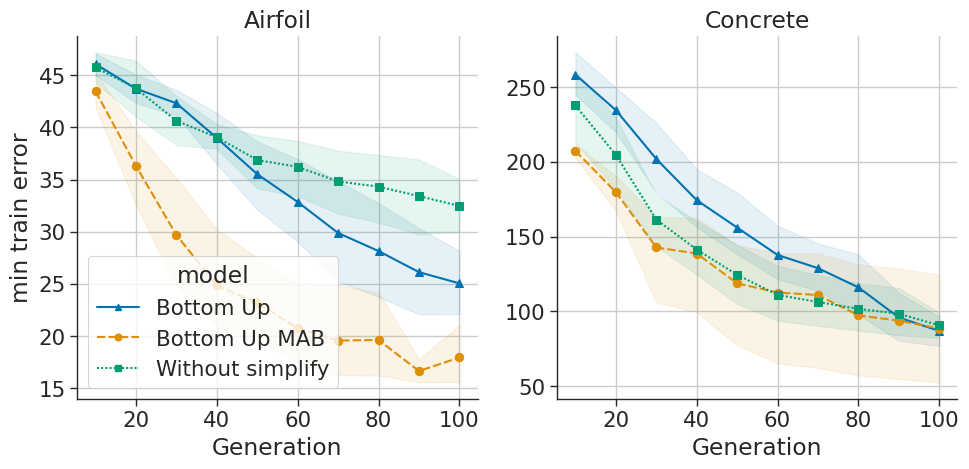

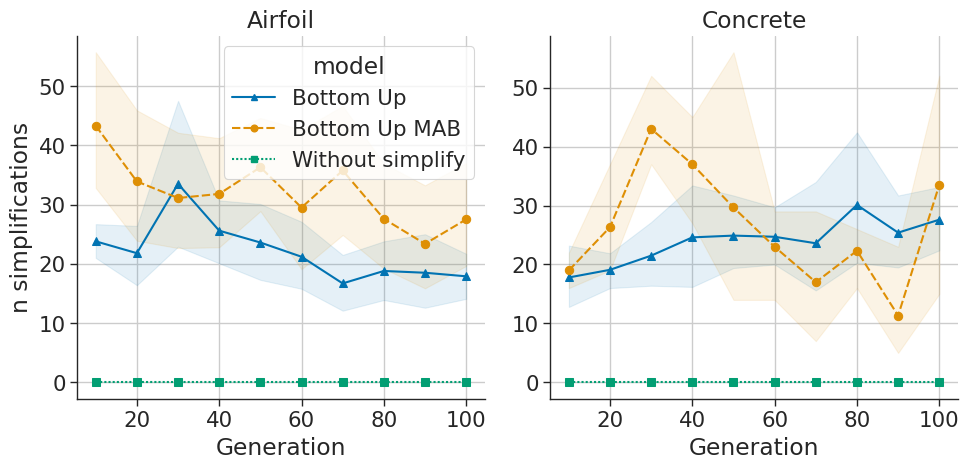

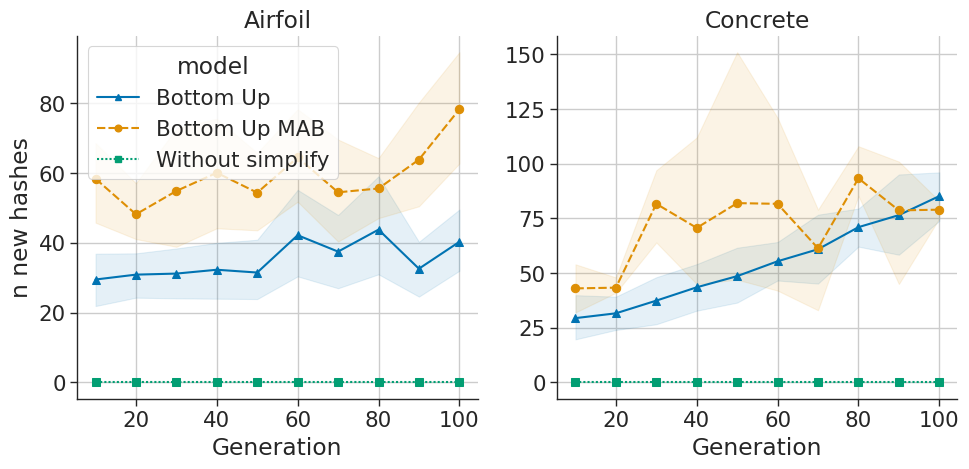

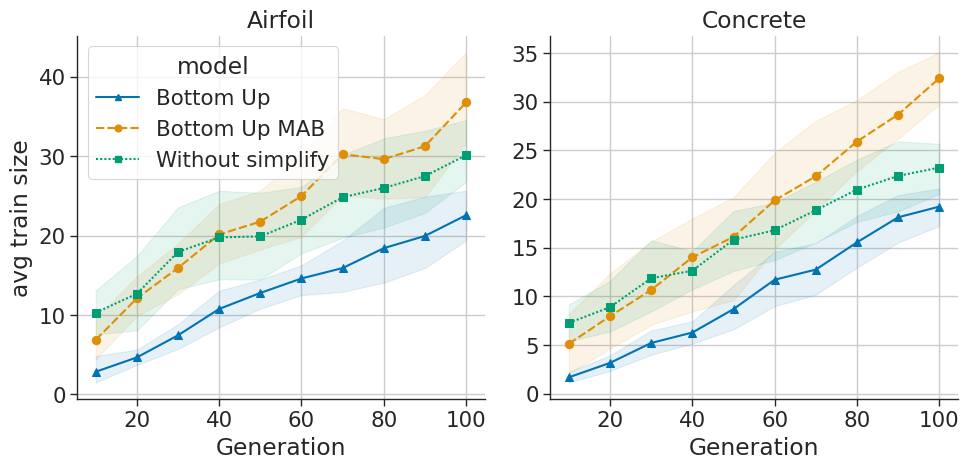

In [3]:
for col in [
    'best_size','min val error', 'min train error',
    'n_simplifications', 'n_new_hashes','avg train size',
    #'med train error','med val error',
]:
    
    # about errors: https://seaborn.pydata.org/tutorial/error_bars.html
    g = sns.relplot(
        data=all_data_df,
        x="gen", y=col, col="dataset", hue="model",
        style="model", col_wrap=col_wrap, markers=marker_choice, markeredgecolor=None, 
        kind="line", facet_kws={'sharey': False, 'sharex': False, 'legend_out':False}, 
        hue_order = order, estimator=np.mean, markersize=6,
        
        #err_style='bars', err_kws={'capsize':0.0, 'linewidth':0.0},
        #err_style='bars', err_kws={'capsize':2.0, 'linewidth':0.5}, # 2.0, 0.5
        err_style='band', err_kws={'alpha':0.1},
    )
    g.set_titles("{col_name}")

    for (ds, plot_ax) in g._axes_dict.items():
        plot_ax.grid(which='major', axis='both', linewidth=1)
        plot_ax.set_xlabel("Generation")
        plot_ax.set_ylabel(plot_ax.get_ylabel().replace('_', ' '))

    if False: # use log scale
        #g.set(xscale="log")
        g.set(yscale="log")

    plt.tight_layout()
    plt.savefig(f"../paper/figs/{col}.pdf")
    plt.savefig(f"../paper/figs/{col}.png")
    plt.show()
    